In [21]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
#from preprocessing.preprocessing_csv import Preprocessing_CSV_Seniority
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
#from preprocessing.preprocessing_json import Preprocessing_JSON_annotated_Seniority
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import train_test_split
import json
from imblearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
import joblib
import shap

#### Preprocessing CSV

In [22]:
class Preprocessing_CSV():
    def __init__(self, file_path: str):
        self.file_path = file_path
        self.df: pd.DataFrame | None = None

        # Label and Text
        self.X: pd.Series = None
        self.y: pd.Series = None

        # Optional: keep raw versions too
        self.X_raw: pd.Series | None = None
        self.y_raw: pd.Series | None = None

        self.read_csv()

    @staticmethod
    def clean_text(text: str) -> str:
        """Lowercase, strip, replace - and / with spaces."""
        return str(text).lower().strip().replace("-", " ").replace("/", " ")

    def read_csv(self):
        """Reads CSV and exposes X (cleaned text) and y (raw text labels)."""
        self.df = pd.read_csv(self.file_path)

        required_cols = {"text", "label"}
        if not required_cols.issubset(self.df.columns):
            raise ValueError("Wrong file mate :( Expected columns: text, label")

        # Raw
        self.X_raw = self.df["text"].astype(str)
        self.y_raw = self.df["label"].astype(str)

        # Cleaned + labels as strings
        self.X = self.X_raw.apply(self.clean_text)
        self.y = self.y_raw

    def label_distribution(self) -> pd.Series:
        """Quick check of label counts."""
        if self.y is None:
            return pd.Series(dtype=int)
        return self.y.value_counts()

#### Pipeline:

1. Load and Prepare CSV Data
2. Load and Prepare not-annotated.json data
3. Concatenate and Train-Test Split
4. Bow and Logistic Regression with Hyperparam Search and 5 Fold CV
5. Test on test set
6. Test on annotated.json -> maybe with .predict_proba()

In [23]:
# 1. Load and Prepare CSV Data
data = Preprocessing_CSV(
    "/Users/jonas/Documents/Master_Vorlesungen/Semester_02/Practical Data Science/Final/PDS_Final/data/seniority-v2.csv"
)

X = data.X
y = data.y

In [24]:
# 2. Load and Prepare not-annotated.json Data
not_annotated_data = pd.read_csv("/Users/jonas/Documents/Master_Vorlesungen/Semester_02/Practical Data Science/Final/PDS_Final/data/labeled_not_annotated.csv")
X_not_annotated = not_annotated_data["position"].astype(str).apply(data.clean_text)
y_not_annotated = not_annotated_data["seniority"].astype(str)

In [25]:
# 3. Concatenate and Train/Test split
X_concat = pd.concat([X, X_not_annotated], ignore_index=True)
y_concat = pd.concat([y, y_not_annotated], ignore_index=True)

ordinal_labels = ["Junior", "Professional", "Senior", "Lead", "Management", "Director"]
encoder = OrdinalEncoder(categories=[ordinal_labels], handle_unknown="use_encoded_value", unknown_value=-1)
y_encoded = encoder.fit_transform(y_concat.values.reshape(-1,1)).flatten()

print("Combined X:", X_concat.shape)
print("Combined y:", y_encoded.shape)
print("Unknown labels encoded as -1:", (y_encoded == -1).sum())
print(y_concat.value_counts())


Combined X: (9732,)
Combined y: (9732,)
Unknown labels encoded as -1: 0
Senior          3897
Lead            3547
Director         984
Management       817
Junior           476
Professional      11
Name: count, dtype: int64


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_concat, y_encoded, test_size=0.2, stratify=y_encoded)

In [27]:
# 4. BOW and Logistic Regression with Hyperparam Search and 5 fold CV

pipe = Pipeline(steps=[
    ("bow", CountVectorizer(ngram_range=(1, 2))),
    ("ros", RandomOverSampler(random_state=123)),
    ("clf", LogisticRegression(max_iter=2000))
])

parameters = {
    "bow__min_df": [1, 2, 3],
    "bow__max_df": [0.9, 0.95, 1.0],
    "clf__C": [0.1, 1, 10],
    "clf__solver": ["liblinear"],
    "clf__class_weight": [None, "balanced"]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    pipe,
    param_grid=parameters,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_

print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best params: {'bow__max_df': 0.9, 'bow__min_df': 3, 'clf__C': 1, 'clf__class_weight': None, 'clf__solver': 'liblinear'}
Best CV score: 0.7935270336481663


In [28]:
# 5. Test on test-set

csv_prediction = best_model.predict(X_test) # Auch predict_proba() probieren
print("Accuracy:", accuracy_score(y_test, csv_prediction))
print(
    classification_report(
        y_test,
        csv_prediction,
        target_names=ordinal_labels)
)

Accuracy: 0.9476117103235747
              precision    recall  f1-score   support

      Junior       0.85      0.85      0.85        95
Professional       0.02      0.50      0.04         2
      Senior       0.99      0.96      0.97       780
        Lead       0.97      0.96      0.97       710
  Management       0.92      0.88      0.90       163
    Director       0.98      0.96      0.97       197

    accuracy                           0.95      1947
   macro avg       0.79      0.85      0.78      1947
weighted avg       0.97      0.95      0.96      1947



In [29]:
# 6. Test on annotated.json

annotated_json_data = pd.read_csv(
    "/Users/jonas/Documents/Master_Vorlesungen/Semester_02/Practical Data Science/Final/PDS_Final/data/highest_active_jobs.csv",
)

X_annotated = annotated_json_data["position"].astype(str).apply(data.clean_text)
y_annotated = annotated_json_data["seniority"].astype(str)

y_annotated_encoded = encoder.transform(y_annotated.values.reshape(-1,1)).flatten()


#X_annotated_bow = bow.transform(X_annotated)

In [30]:
predict_annotated = best_model.predict(X_annotated)

print(f"Accuracy on annotated.json: {accuracy_score(y_annotated_encoded, predict_annotated)}")

print(
    classification_report(
        y_annotated_encoded,
        predict_annotated,
        target_names=ordinal_labels,
        zero_division=0
    )
)

Accuracy on annotated.json: 0.5376569037656904
              precision    recall  f1-score   support

      Junior       0.14      0.50      0.22         8
Professional       0.55      0.47      0.51       167
      Senior       0.28      0.83      0.42        41
        Lead       0.79      0.42      0.54        89
  Management       0.85      0.55      0.66       150
    Director       0.50      0.91      0.65        23

    accuracy                           0.54       478
   macro avg       0.52      0.61      0.50       478
weighted avg       0.66      0.54      0.56       478



<Figure size 12000x12000 with 0 Axes>

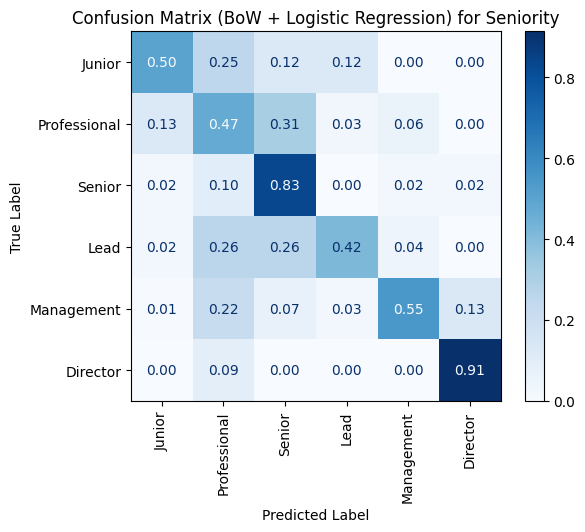

In [31]:
cm_norm = confusion_matrix(
    y_annotated_encoded,
    predict_annotated,
    normalize="true"
)

plt.figure(figsize=(20, 20), dpi=600)

display = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=ordinal_labels)
display.plot(cmap="Blues", xticks_rotation=90, values_format=".2f")

plt.title("Confusion Matrix (BoW + Logistic Regression) for Seniority")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig("plots/cm_bow_seniority.png", bbox_inches="tight")
plt.show()

In [ ]:
# 7. Save Model + Encoder
joblib.dump(best_model, "/Users/jonas/Documents/Master_Vorlesungen/Semester_02/Practical Data Science/Final/PDS_Final/models_done/bow_seniority.joblib")
joblib.dump(encoder, "/Users/jonas/Documents/Master_Vorlesungen/Semester_02/Practical Data Science/Final/PDS_Final/models_done/encoder_seniority.joblib")

['/Users/jonas/Documents/Master_Vorlesungen/Semester_02/Practical Data Science/Final/PDS_Final/models_done/encoder_seniority.joblib']

In [ ]:
# 8. SHAP Model explanations
bow_model = best_model.named_steps["bow"]
lr_model = best_model.named_steps["clf"]

X_train_vectorized = bow_model.transform(X_train)
X_test_vectorized = bow_model.transform(X_test)

feature_names = bow_model.get_feature_names_out()

random_num_generator = np.random.RandomState(123)
background_idx = random_num_generator.choice(X_train_vectorized.shape[0], size=min(500, X_train_vectorized.shape[0]), replace=False)
X_background = X_train_vectorized[background_idx]

explainer = shap.LinearExplainer(lr_model, X_background, feature_names=feature_names)

n_explain = min(200, X_test_vectorized.shape[0])
X_explain = X_test_vectorized[:n_explain]
shap_values = explainer(X_explain)

Classes: [0. 1. 2. 3. 4. 5.]


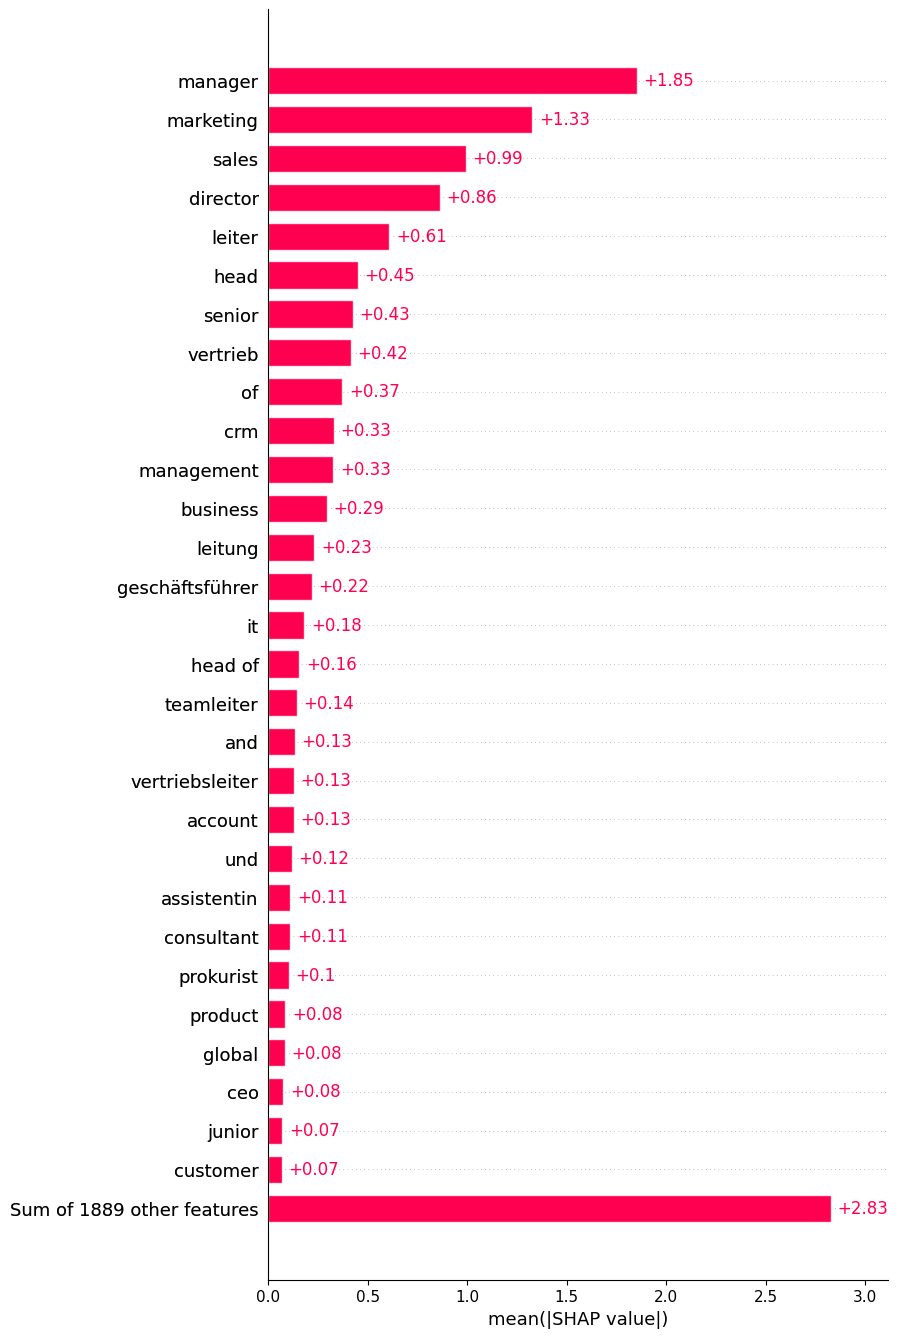

In [37]:
print("Classes:", lr_model.classes_)

# Only Shows for one class. Change class_name
class_name = lr_model.classes_[1]
class_id = list(lr_model.classes_).index(class_name)

shap_values_class = shap.Explanation(
    values=shap_values.values[:, :, class_id],
    base_values=np.array(shap_values.base_values)[:, class_id],
    data=shap_values.data,
    feature_names=shap_values.feature_names
)

shap.plots.bar(shap_values_class, max_display=30)
plt.show()

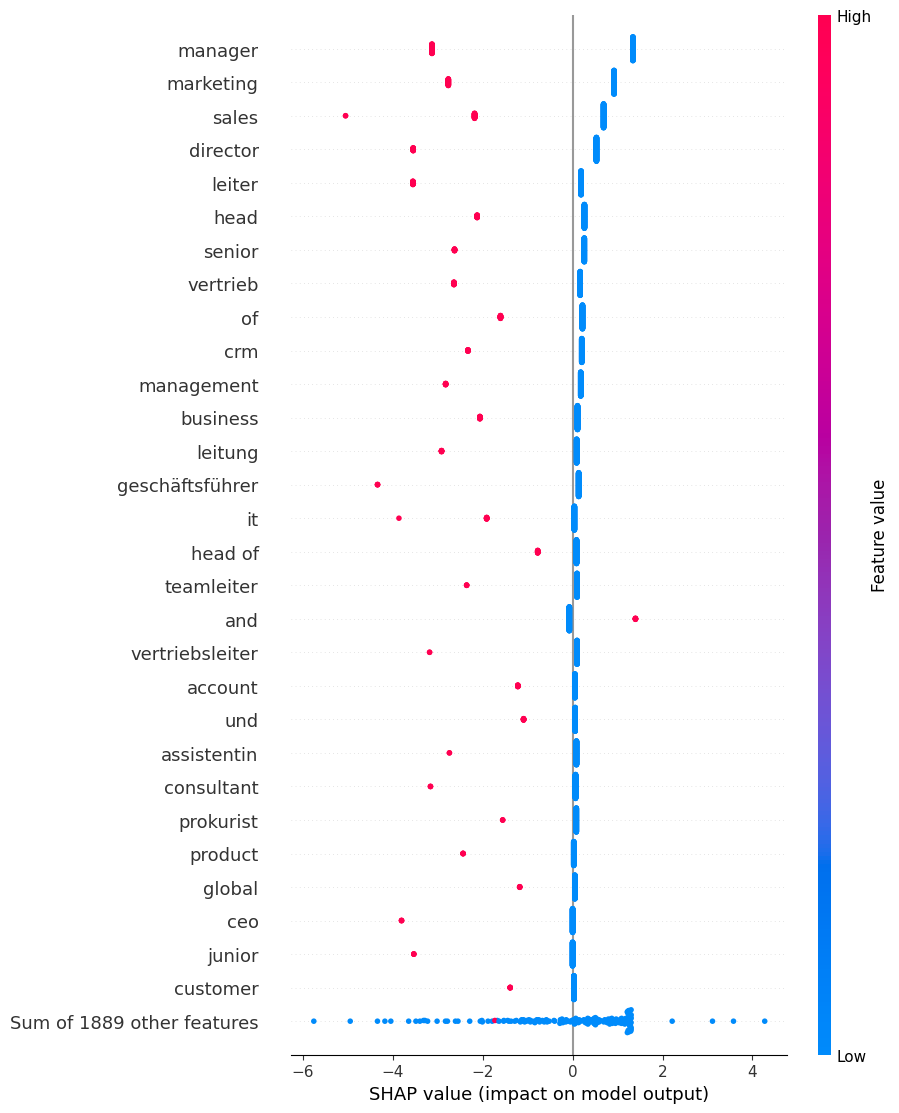

In [38]:
shap.plots.beeswarm(shap_values_class, max_display=30)
plt.show()

Waterfall explanation for class: 1.0


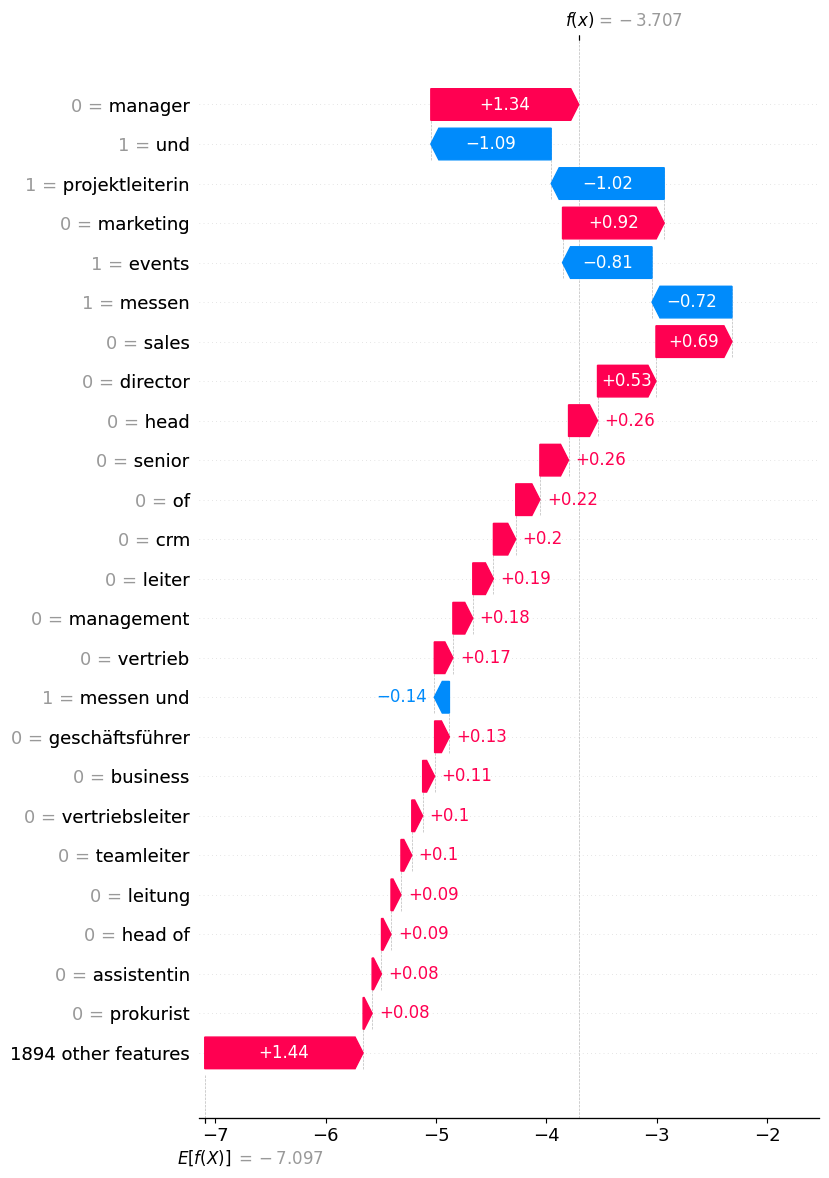

In [39]:
i = 195 # Feature

x_row = X_explain[i].toarray().ravel()

sv_i = shap.Explanation(
    values=shap_values.values[i, :, class_id],
    base_values=np.array(shap_values.base_values)[i, class_id],
    data=x_row,
    feature_names=shap_values.feature_names
)

print("Waterfall explanation for class:", class_name)
shap.plots.waterfall(sv_i, max_display=25)
plt.show()